[![Open In Colab](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&label=%20&labelColor=5c5c5c&color=23c7a2&style=flat-square)](https://colab.research.google.com/github/einbandi/paradime/blob/master/notebooks/supervised.ipynb)

# Supervised DR with a Custom Loss

In this example, we'll set up a supervised dimensionality reduction routine based on t-SNE. First, we'll create a ParaDime routine for plain parametric t-SNE, which is similar to how the predefined [ParametricTSNE](../api/modules.rst#paradime.routines.ParametricTSNE) is set up. Afterwards, we'll explore the effects of an additional custom loss that takes class label information into account. This additional loss is based on the triplet margin loss.

## The Cover Type Dataset

We will use our custom routine to create embeddings of the forest cover type dataset. This dataset consists of cartographic variables that can be used to predict the type of forest that covers an area. Each data point has 54 attributes and is labeled as one of 7 types of forest.

First, let's import the relevant submodules from ParaDime, along with a couple of other packages. We'll take the covertype dataset from sklearn, and we'll also use sklearn's TSNE to see how our parametric verison compares against a non-parametric one.

In [1]:
import sys
sys.path.append("../../")

import numpy as np
import torch
import sklearn.datasets
import sklearn.decomposition
import sklearn.manifold
import sklearn.preprocessing
from matplotlib import pyplot as plt

import paradime.dr
import paradime.relations
import paradime.transforms
import paradime.loss
import paradime.utils

paradime.utils.seed.seed_all(42);

In [2]:
covertype = sklearn.datasets.fetch_covtype()

The covertype dataset is highly unbalanced, i.e., it has many more entries for certain classes than others. In this example, we want to use a balanced subset of the dataset. To obtain this subset, we first count how often each class is present. We then invert these counts to compute weights and draw 7000 sample indices with a WeightedRandomSampler, which should lead to a roughly balanced dataset.

In [5]:
_, counts = np.unique(covertype.target, return_counts=True)
weights = np.array([ 1/counts[i-1] for i in covertype.target ])

In [6]:
indices = list(torch.utils.data.WeightedRandomSampler(weights, 7000))

Finally, we standardize the data. Note that in this example we only use the first ten features of the covertype dataset, which are all numerical. The remaining 44 attributes are categorical and would require a slightly special treatment for use with a NN model.

In [7]:
raw_data = covertype.data[indices,:10]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(raw_data)
data = scaler.transform(raw_data)

The class labels in the covertype dataset are integers from 1 to 7. Here's how they map to the actual class names:

In [8]:
label_to_name = {
    1: "Spruce/fir",
    2: "Lodgepole pine",
    3: "Ponderosa pine",
    4: "Cottonwood/willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz",
}

In [9]:
tsne_global_rel = paradime.relations.NeighborBasedPDist(
    transform=[
        paradime.transforms.PerplexityBasedRescale(
            perplexity=200, bracket=[0.001, 1000]
        ),
        paradime.transforms.Symmetrize(),
        paradime.transforms.Normalize(),
    ]
)

In [10]:
tsne_batch_rel = paradime.relations.DifferentiablePDist(
    transform=[
        paradime.transforms.StudentTTransform(alpha=1.0),
        paradime.transforms.Normalize(),
        paradime.transforms.ToSquareTensor(),
    ]
)

In [11]:
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(data)


Finally, we define two training phases: one for the initilaization, using a [PositionLoss](../api/modules.rst#paradime.loss.PositionLoss) on the PCA coordinates; and one for the main embedding, using a [RelationLoss](../api/modules.rst#paradime.loss.RelationLoss) on the global and batch-wise relations (i.e., probabilities). We'll reuse the initialization phase later.

In [12]:
tsne_init = paradime.dr.TrainingPhase(
    name="pca_init",
    loss=paradime.loss.PositionLoss(position_key="pca"),
    batch_size=500,
    epochs=10,
    learning_rate=0.01,
)

tsne_main = paradime.dr.TrainingPhase(
    name="embedding",
    loss=paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div
    ),
    batch_size=500,
    epochs=40,
    learning_rate=0.02,
    report_interval=2,
)

We can now set up our routine and train it:

In [13]:
pd_tsne = paradime.dr.ParametricDR(
    global_relations=tsne_global_rel,
    batch_relations=tsne_batch_rel,
    in_dim=10,
    out_dim=2,
    hidden_dims=[100,50],
    dataset=data,
    use_cuda=True,
    verbose=True,
)
pd_tsne.add_to_dataset({"pca": pca})
pd_tsne.add_training_phase(tsne_init)
pd_tsne.add_training_phase(tsne_main)

pd_tsne.train()

2022-09-24 17:13:24,355: Registering dataset.
2022-09-24 17:13:24,509: Adding entry 'pca' to dataset.
2022-09-24 17:13:24,510: Computing global relations 'rel'.
2022-09-24 17:13:24,510: Indexing nearest neighbors.


KeyboardInterrupt: 

Once the training has completed we can visualize our parametric t-SNE of the covertype subset:

<AxesSubplot:>

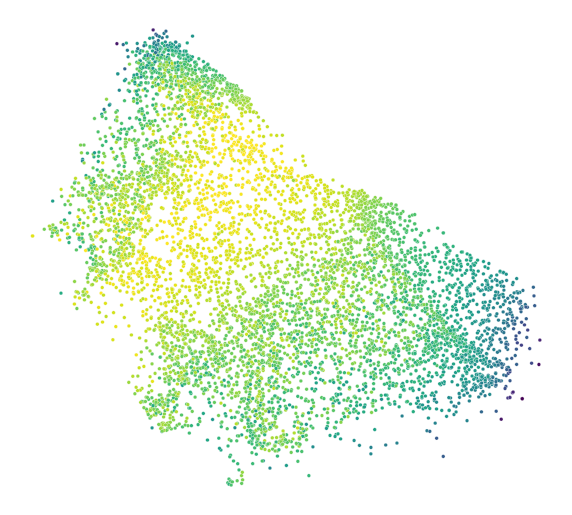

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

paradime.utils.plotting.scatterplot(
    pd_tsne.apply(data),
    # labels=[label_to_name[i] for i in covertype.target[indices]],
    c=data[:,7],
    legend=False,
    ax=ax,
    # legend_options={"loc": 1}
)

# fig.savefig("unguided-tsne.png", bbox_inches = "tight")

Notice how the overall shape and banding structure is very similar to the "exact" t-SNE.

## Supervised Parametric t-SNE

Since the class clusters overlap quite strongly, we would like to see if we can make them a bit more compact by introducing a supervision in our routine. This will make use of the class labels to artificially separate the class clusters.

One promising type of loss for this task is the so-called triplet loss. It basically looks at triplets of datapoints, where one datapoint is the so called anchor, one is a *positive* example (with the same label as the anchor), and one a *negative* example (with a different label). The loss then tries to maximize the difference of the distance between anchor and positive, and anchor and negative examples. This essentiall pulls points with equal labels closer together, while pushing points with different labels further apart.

The triplet loss is implemented in PyTorch as [TripletMarginLoss](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html). To make use of it in a ParaDime routine, we have to make sure it is applied correctly to triplets of data samples. We do this by writing a custom [Loss](../api/modules.rst#paradime.loss.Loss) class:

In [14]:
class GuidingLoss(paradime.loss.Loss):
    """Triplet loss for supervised DR.

    To be used with negative edge sampling with sampling rate 1.
    """

    def __init__(self, attr_index, emb_dim, name=None):
        super().__init__(name)

        self.attr_index = attr_index
        self.emb_dim = emb_dim

    def forward(self, model, global_relations, batch_relations, batch, device):

        data = batch["data"].to(device)
        emb = model.embed(data)

        chosen_attr = data[:, self.attr_index]
        chosen_emb_coord = emb[:, self.emb_dim]

        cov = torch.cov(
            torch.stack((chosen_attr, chosen_emb_coord))
        )

        corr = cov[0,1] / (chosen_attr.std() * chosen_emb_coord.std())

        loss = 1 - corr**2

        return loss


In a custom ParaDime [Loss](../api/modules.rst#paradime.loss.Loss), we basically only have to define a `forward` method for the loss with a given call signature. As explained in the section about [Building Blocks of a ParaDime Routine](building_blocks.rst), the loss gets passed the model, the computed global relation data, the batch-relation "recipes", the batch of data, and the device on which the model lives. To obtain triplets, we can make use of the negative edge sampling provided by ParaDime. A batch of negative-edge sampled dataconsists of 1 + *n* copies of each data point, together with one actually neighboring sample and *n* non-neighboring samples (*n* is the negative sampling rate). Whether or not two data points are consideres as neighbors is governed by a some global relations between data points. If we construct our negative edge sampler with a negative samplnig rate of 1 and with the correct relations, we'll obtain triplets directly in the batch's `'from_to_data'` attribute.

Let's now construct these relations separately. In our case, two datapoints should be considered "neighbors" if they have the same target label. We'll construct a matrix of zeros and ones for our data subset, where 1 means "same label" and 0 means "different label":

In [15]:
labels = covertype.target[indices]

same_label = (np.outer(labels, np.ones_like(labels))
    - np.outer(np.ones_like(labels), labels) == 0).astype(float)

All that's left to do now is to:
 1. Add the above relations as a second global relation entry to our routine (we can use the [Precomputed](../api/modules.rst#paradime.relations.Precomputed) relations interface);
 2. configure our main training phase to use negative edge sampling;
 3. tell it to use the above relations as a basis for sampling; and
 4. change the loss from a pure t-SNE loss to a [CompoundLoss](../api/modules.rst#paradime.loss.CompoundLoss) with our `TripletLoss`.

In [16]:
weights = [100, 500, 1000, 2000, 5000, -1]
embeddings = []

for w in weights:
    super_tsne = paradime.dr.ParametricDR(
        global_relations={
            "tsne": tsne_global_rel,
        },
        batch_relations=tsne_batch_rel,
        in_dim=10,
        out_dim=2,
        hidden_dims=[100, 50],
        dataset=data,
        use_cuda=True,
        verbose=True,
    )
    super_tsne.add_to_dataset({"pca": pca})
    super_tsne.add_training_phase(tsne_init)
    super_tsne.add_training_phase(
        name="embedding",
        loss=paradime.loss.CompoundLoss(
            [
                paradime.loss.RelationLoss(
                    loss_function=paradime.loss.kullback_leibler_div,
                    global_relation_key="tsne",
                ),
                GuidingLoss(7, 0),
            ],
            weights=[w if w != -1 else 1, 1 if w != -1 else 0],
        ),
        batch_size=500,
        epochs=40,
        learning_rate=0.02,
        report_interval=2,
    )
    super_tsne.train()

    torch.save(super_tsne.model.state_dict(), f"models/guided-w{w}.pt")

    embeddings.append(super_tsne.apply(data))


2022-09-24 17:15:12,566: Registering dataset.
2022-09-24 17:15:12,568: Adding entry 'pca' to dataset.
2022-09-24 17:15:12,581: Computing global relations 'tsne'.
2022-09-24 17:15:12,582: Indexing nearest neighbors.
2022-09-24 17:15:30,757: Calculating probabilities.
2022-09-24 17:15:31,877: Beginning training phase 'pca_init'.
2022-09-24 17:15:35,458: Loss after epoch 0: 15.271630555391312
2022-09-24 17:15:35,912: Loss after epoch 5: 0.017860275460407138
2022-09-24 17:15:36,228: Beginning training phase 'embedding'.
2022-09-24 17:15:37,774: Loss after epoch 0: 7.637599617242813
2022-09-24 17:15:40,749: Loss after epoch 2: 5.4123295545578
2022-09-24 17:15:43,664: Loss after epoch 4: 5.25399175286293
2022-09-24 17:15:46,841: Loss after epoch 6: 5.176105469465256
2022-09-24 17:15:49,762: Loss after epoch 8: 5.148834556341171
2022-09-24 17:15:52,816: Loss after epoch 10: 5.044099807739258
2022-09-24 17:15:55,998: Loss after epoch 12: 5.033698886632919
2022-09-24 17:15:59,056: Loss after ep

The only tricky part here is to set the correct weight for each loss component in the compound loss. One way to do this is to start with some best guess for the weights, train the routine, and then inspect both the total loss's and the individual losses' histories. You can access the history of the total loss via `super_tsne.training_phases[1].loss.history`, and of the weighted histories of the individual losses via `super_tsne.training_phases[1].loss.detailed_history()`.

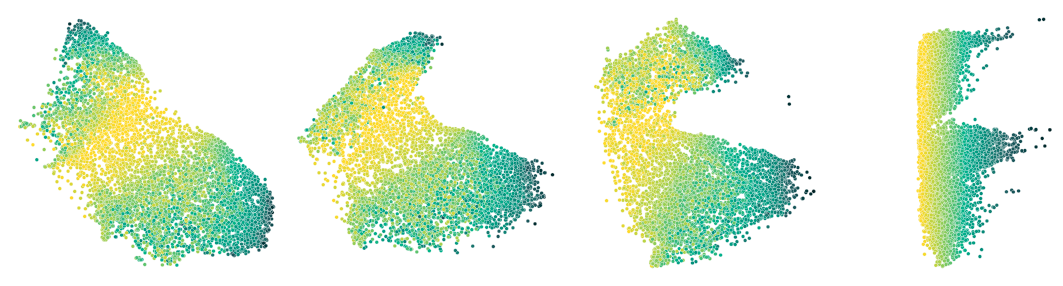

In [282]:
fig = plt.figure(figsize=(20,5))
indices = [5, 4, 2, 0]
for i, j in enumerate(indices):
    ax = fig.add_subplot(1,len(indices), i + 1)
    # ax.set_title(weights[j])
    paradime.utils.plotting.scatterplot(
        embeddings[j],
        c=data[:,7],
        cmap=paradime.utils.plotting.get_colormap(),
        ax=ax,
    )
fig.subplots_adjust(wspace=0)

fig.savefig("guided-scatter.png", bbox_inches = "tight")

In [293]:
[weights[i] for i in [5, 4, 2, 0]]

[-1, 5000, 1000, 100]

Clearly, the triplet loss pulled apart the different classes, while the overall structure (the "bands" and their relative ordering) was preserved due to the compound loss with the t-SNE component.

In [169]:
unguided = paradime.dr.ParametricDR(
        in_dim=10,
        out_dim=2,
        hidden_dims=[100, 50],
)
unguided.model.load_state_dict(torch.load("models/guided-w-1.pt"))
unguided.trained = True

grads_x_unguided = []
grads_y_unguided = []
for d in data:
    unguided.model.forward(torch.tensor(d).float().cpu())[0].backward()
    grads_x_unguided.append(unguided.model.layers[0].weight.grad.sum(dim=0))
    unguided.model.zero_grad()

    unguided.model.forward(torch.tensor(d).float().cpu())[1].backward()
    grads_y_unguided.append(unguided.model.layers[0].weight.grad.sum(dim=0))
    unguided.model.zero_grad()

grads_x_unguided = torch.stack(grads_x_unguided)
grads_y_unguided = torch.stack(grads_y_unguided)

In [170]:
guided = paradime.dr.ParametricDR(
        in_dim=10,
        out_dim=2,
        hidden_dims=[100, 50],
)
guided.model.load_state_dict(torch.load("models/guided-w100.pt"))
guided.trained = True

grads_x_guided = []
grads_y_guided = []
for d in data:
    guided.model.forward(torch.tensor(d).float().cpu())[0].backward()
    grads_x_guided.append(guided.model.layers[0].weight.grad.sum(dim=0))
    guided.model.zero_grad()

    guided.model.forward(torch.tensor(d).float().cpu())[1].backward()
    grads_y_guided.append(guided.model.layers[0].weight.grad.sum(dim=0))
    guided.model.zero_grad()
    
grads_x_guided = torch.stack(grads_x_guided)
grads_y_guided = torch.stack(grads_y_guided)

In [105]:
import pandas as pd
import seaborn as sns

In [222]:
# feature_names = [
#     "Elevation",
#     "Aspect",
#     "Slope",
#     "Water dist (h)",
#     "Water dist (v)",
#     "Road dist (h)",
#     "Shade (9am)",
#     "Shade (noon)",
#     "Shade (3pm)",
#     "Fire dist (h)",
# ]

feature_names = [ str(i) for i in np.arange(1, 11) ]

guided_total_x = grads_x_guided.mean(dim=0).abs().sum()
guided_total_y = grads_y_guided.mean(dim=0).abs().sum()
unguided_total_x = grads_x_unguided.mean(dim=0).abs().sum()
unguided_total_y = grads_y_unguided.mean(dim=0).abs().sum()

df = pd.DataFrame()
df["Importance"] = np.concatenate(
    (
        grads_x_guided.flatten() / guided_total_x,
        grads_y_guided.flatten() / guided_total_y,
        grads_x_unguided.flatten() / unguided_total_x,
        grads_y_unguided.flatten() / unguided_total_y,
    )
)
df["Feature"] = np.tile(np.tile(feature_names, len(grads_x_guided)), 4)
df["Axis"] = np.tile(
    np.repeat(["x", "y"], len(grads_x_guided) * len(feature_names)), 2
)
df["Guided"] = np.repeat(
    [True, False], 2 * len(grads_x_guided) * len(feature_names)
)

# df_guided = pd.DataFrame()
# df_guided["Feature"] = np.tile(feature_names, len(grads_x_guided))
# df_guided["Axis"] = "x"
# df_guided["Importance"] = torch.stack(grads_x_guided).flatten()
# df_guided["Guided"] = True


# df_guided = pd.DataFrame()
# df_guided["Feature"] = np.tile(feature_names, len(grads_x_guided))
# df_guided["Axis"] = "x"
# df_guided["Importance"] = torch.stack(grads_x_guided).flatten()
# df_guided["Guided"] = True


# df_guided = pd.DataFrame()
# df_guided["Feature"] = np.tile(feature_names, len(grads_x_guided))
# df_guided["Axis"] = "x"
# df_guided["Importance"] = torch.stack(grads_x_guided).flatten()
# df_guided["Guided"] = True

# df_guided = pd.DataFrame()
# df_guided["Feature"] = np.tile(feature_names, len(grads_x_guided))
# df_guided["Axis"] = "x"
# df_guided["Importance"] = torch.stack(grads_x_guided).flatten()
# df_guided["Guided"] = True


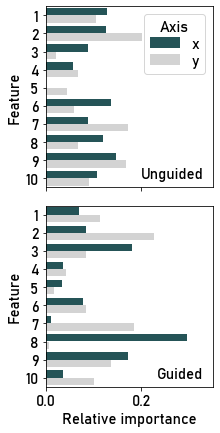

In [284]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Bahnschrift"]
plt.rcParams["font.size"] = 15
plt.rcParams["legend.labelspacing"] = 0.2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 7))

pd_palette = paradime.utils.plotting.get_color_palette()
palette = [pd_palette["petrol"], "lightgrey"]

sns.barplot(
    data=df[~df["Guided"]],
    y="Feature",
    x="Importance",
    hue="Axis",
    palette=palette,
    estimator=lambda x: abs(np.mean(x)),
    ci=None,
    ax=ax1,
)
ax1.set_xlabel("")
ax1.set_xticklabels("")
ax1.set_xlim(0, 0.35)
ax1.text(0.33, 9.0, "Unguided", ha="right")
# ax1.set_xticklabels(
#         ax1.get_xticklabels(), 
#         rotation=30, 
#         horizontalalignment='right'
#     )

sns.barplot(
    data=df[df["Guided"]],
    y="Feature",
    x="Importance",
    hue="Axis",
    palette=palette,
    estimator=lambda x: abs(np.mean(x)),
    ci=None,
    ax=ax2,
)
ax2.legend()
ax2.set_xlabel("Relative importance")
ax2.set_xlim(0, 0.35)
# ax2.set_xticklabels(
#         ax2.get_xticklabels(), 
#         rotation=30, 
#         horizontalalignment='right'
#     )
ax2.legend([],[], frameon=False)
ax2.text(0.33, 9.0, "Guided", ha="right")

fig.subplots_adjust(hspace=0.1)

fig.savefig("guided-bar.pdf", bbox_inches = "tight")

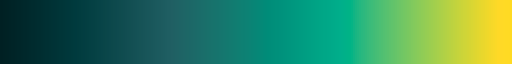

In [281]:
paradime.utils.plotting.get_colormap()

In [286]:
min(data[:,7])

-5.3268422945217155

In [287]:
max(data[:,7])

1.5112961871241477

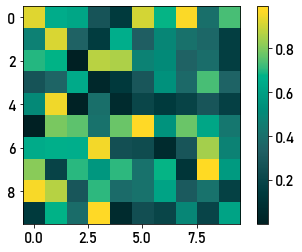

In [292]:
mat = np.random.random((10,10))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plot = ax.imshow(mat, cmap=paradime.utils.plotting.get_colormap())
fig.colorbar(plot)
fig.savefig("legend.png")